## Imports

In [1]:
import pandas as pd
import torch
import pytorch_forecasting
from pytorch_lightning import Trainer

## Concept

1. Static Metadata, Time-varying Past Inputs, Time-varying Future Inputs을 Input Data로 활용
2. 모든 Inputs은 변수 선택 단계(VSN)를 거쳐 정적 공변량과 Time-varying Inputs들이 함께 LSTM layer에 입력됨
3. Time-varying Past Inputs은 Encoder에, Time-varying Future Inputs은 Decoder에 입력
4. LSTM total layer outputs과 정적 공변량 데이터를 GRN layer에 합께 입력한 후, Masked Interpretable Multi-head attention layer에 입력
5. 최종적으로 LSTM decoder 산출 값과 GRN을 거친 attention layer의 산출 값을 결합하여 quantile forecase를 진행

## 사용법

In [ ]:
#!pip install tensorflow
#!pip install tensorboard
#!pip install optuna statsmodels
#!pip install optuna-integration[pytorch_lightning]

In [2]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.examples import get_stallion_data

### Preprocessing

In [3]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data() ## pandas df

## add time index
data["time_idx"] = data["date"].dt.year*12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min() ## monto 단위, 0 to fin, 시점 당 350개 데이터

## add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")

## special days encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]

## 이게 뭐임? 데이터프레임에 들어간 게 아니네?
data[special_days] = (
    data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
)

### Create dataset and dataloaders

In [4]:
max_prediction_length = 6   ## validation length
max_encoder_length = 24     ## encoding length
training_cutoff = data["time_idx"].max() - max_prediction_length ## 훈련 데이터 종료 시점

training = TimeSeriesDataSet(
    data[lambda x : x.time_idx <= training_cutoff],
    time_idx = "time_idx", ## integer. 0 >=
    target = "volume",
    group_ids = ["agency", "sku"], ## TimeSeries Group
    min_encoder_length = max_encoder_length // 2, ## 인코더 길이 길게 유지
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    static_categoricals = ["agency", "sku"], ## 분리되는 요소만 시점에 불변
    static_reals = ["avg_population_2017", "avg_yearly_household_income_2017"], ## 수치형 중에선 평균값만 불변
    time_varying_known_categoricals = ["special_days", "month"], ## 시간에 따라 바뀌는 카테고리
    variable_groups = {
        "special_days" : special_days
    }, ## 한 개의 변수로 설명 가능
    time_varying_known_reals = ["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals = [
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ], ## 정보 유출?
    target_normalizer = GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  ## use softplus and normalize by group -> ReLU랑 비슷함
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True
)

## create validation set
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict = True, stop_randomization = True
)

## create dataloaders for model
batch_size = 32
train_dataloader = training.to_dataloader(
    train = True, batch_size = batch_size, num_workers = 0
)
val_dataloader = validation.to_dataloader(
    train = False, batch_size = batch_size * 10, num_workers = 0
)

### Modeling

In [5]:
baseline_predictions = Baseline().predict(val_dataloader, return_y = True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
2025-08-11 13:35:57.605644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754886957.620947   91168 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754886957.625966   91168 cuda_bl

tensor(0.4709, device='cuda:0')

In [5]:
pl.seed_everything(42) ## setting pytorch lightning seed

trainer = pl.Trainer(
    accelerator = "gpu",
    gradient_clip_val = 0.1
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 8,
    attention_head_size = 1,
    dropout = 0.1, ## 0.1 to 0.3
    hidden_continuous_size = 8, ## <= hidden_size
    loss = QuantileLoss(),
    optimizer = "ranger",
    # reduce_on_plateau_patience = 1000 ## 에폭 이후에도 validation loss 미감소시 사용
)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.5k


/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 4.7863009232263824e-05
Restoring states from the checkpoint path at /root/Dacon_comp/2025 전력사용량 예측/model review/.lr_find_b40d33f6-29af-4213-beda-058516dfd8e5.ckpt
Restored all states from the checkpoint at /root/Dacon_comp/2025 전력사용량 예측/model review/.lr_find_b40d33f6-29af-4213-beda-058516dfd8e5.ckpt


suggested learning rate: 4.7863009232263824e-05


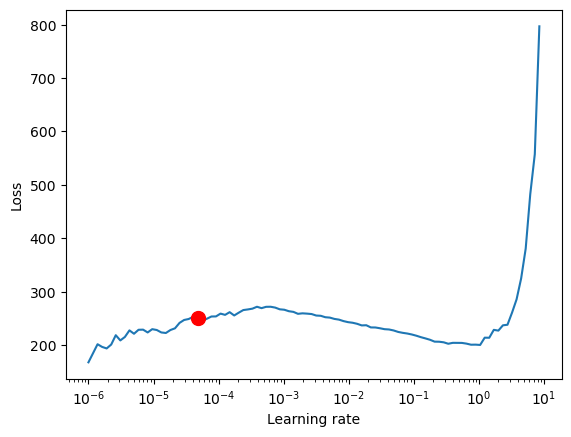

In [7]:
## find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
    max_lr = 10.0,
    min_lr = 1e-6
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train

In [8]:
early_stop_callback = EarlyStopping(
    monitor = "val_loss", min_delta = 1e-4, patience = 10, verbose = False, mode = "min"
)
lr_logger = LearningRateMonitor() ## log the learning rate
logger = TensorBoardLogger("lightning_logs") ## logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs = 50,
    accelerator = "gpu",
    enable_model_summary = True,
    gradient_clip_val = 0.1,
    limit_train_batches = 50, ## comment in for training, running validation every 30 batches
    callbacks = [lr_logger, early_stop_callback],
    logger = logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 16,
    attention_head_size = 2,
    dropout = 0.1,
    hidden_continuous_size = 8,
    loss = QuantileLoss(),
    log_interval = 10, ## 10 batchs마다 로그
    optimizer = "ranger",
    reduce_on_plateau_patience = 4
)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.4k


/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [9]:
## fit network
trainer.fit(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
predictions = trainer.model.predict(val_dataloader, return_y = True, trainer_kwargs = dict(accelerator = "gpu"))
SMAPE()(predictions.output, predictions.y) ## Baseline보다 못한데요...? 아직 덜됐나...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/root/anaconda3/envs/trch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


tensor(0.6430, device='cuda:0')

### Hyperparameter Tuning

In [ ]:
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

## save study results
# with open("test_study.pkl", "wb") as f :
#     pickle.dump(study, f)
    
## show best hyperparameters
print(study.best_trial.params)

## Data

In [105]:
df_train = pd.read_csv("/root/Dacon_comp/2025 전력사용량 예측/train.csv")
df_test = pd.read_csv("/root/Dacon_comp/2025 전력사용량 예측/test.csv")
building_info = pd.read_csv("/root/Dacon_comp/2025 전력사용량 예측/building_info.csv")

df_train = df_train.rename({pre:new for pre, new in zip(df_train.columns, ["num_date_time", "build_num", "date", "temp", "precip", "wind", "humidity", "sunhour", "sunweight", "power"])}, axis = 1)
df_test = df_test.rename({pre:new for pre, new in zip(df_test.columns, ["num_date_time", "build_num", "date", "temp", "precip", "wind", "humidity", "sunhour", "sunweight"])}, axis = 1)

In [106]:
## information processing
building_info = building_info.replace("-", "0").rename({c:n for c, n in zip(building_info.columns, ["build_num", "build_type", "GFA", "CA", "solar_gen", "ESS", "PCS"])}, axis = 1)\
    .assign(solar_gen = lambda _df : _df.solar_gen.astype("float64"))\
    .assign(ESS = lambda _df : _df.ESS.astype("float64"))\
    .assign(PCS = lambda _df : _df.PCS.astype("float64"))
    
## one-hot encoding
building_info = pd.get_dummies(building_info, dtype = int)
building_info = building_info.rename({c:f"type_{i}" for i, c in enumerate(building_info.columns[6:])}, axis = 1)

In [107]:
## dttm으로 타입 변경
df_train["date"] = pd.to_datetime(df_train.date)
df_test["date"] = pd.to_datetime(df_test.date)
holilist = ["06-06", "08-15"] ## 2024 추석은 9월 17일

## train data
del_time = df_train.date - df_train.date.min()
df_train["time_idx"] = del_time.dt.days*24 + del_time.dt.seconds//3600
df_train["month"] = df_train.date.dt.month.astype(str).astype("category")
df_train["wday"] = df_train.date.dt.weekday.astype(str).astype("category")
df_train["is_holiday"] = df_train.date.astype(str).str[5:10].map(lambda x : 1 if x in holilist else 0)
df_train.drop(["num_date_time", "date"], axis = 1)
df_train = pd.merge(df_train, building_info, on = "build_num")

## 일단 국경일 이외 special day는 다루지 않기로 함

## test data
del_time = df_test.date - df_train.date.min()
df_test["time_idx"] = del_time.dt.days*24 + del_time.dt.seconds//3600
df_test["month"] = df_test.date.dt.month.astype(str).astype("category")
df_test["wday"] = df_test.date.dt.weekday.astype(str).astype("category")
df_test["is_holiday"] = 0 ## 8.25 이후 휴일 없음
df_test.drop(["num_date_time", "date"], axis = 1)
df_test = pd.merge(df_test, building_info, on = "build_num")

In [112]:
set(df_train.columns) - set(df_test.columns)

{'power', 'sunhour', 'sunweight'}

In [ ]:
max_prediction_length = 6   ## validation length
max_encoder_length = 24     ## encoding length
training_cutoff = data["time_idx"].max() - max_prediction_length ## 훈련 데이터 종료 시점

training = TimeSeriesDataSet(
    data[lambda x : x.time_idx <= training_cutoff],
    time_idx = "time_idx", ## integer. 0 >=
    target = "volume",
    group_ids = ["agency", "sku"], ## TimeSeries Group
    min_encoder_length = max_encoder_length // 2, ## 인코더 길이 길게 유지
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    static_categoricals = ["agency", "sku"], ## 분리되는 요소만 시점에 불변
    static_reals = ["avg_population_2017", "avg_yearly_household_income_2017"], ## 수치형 중에선 평균값만 불변
    time_varying_known_categoricals = ["special_days", "month"], ## 시간에 따라 바뀌는 카테고리
    variable_groups = {
        "special_days" : special_days
    }, ## 한 개의 변수로 설명 가능
    time_varying_known_reals = ["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals = [
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ], ## 정보 유출?
    target_normalizer = GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  ## use softplus and normalize by group -> ReLU랑 비슷함
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True
)

## create validation set
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict = True, stop_randomization = True
)

## create dataloaders for model
batch_size = 32
train_dataloader = training.to_dataloader(
    train = True, batch_size = batch_size, num_workers = 0
)
val_dataloader = validation.to_dataloader(
    train = False, batch_size = batch_size * 10, num_workers = 0
)

## Learning